# Quantum Resource Estimation 2021 Demo
This file contains example code and explanation of the Quantmark VQE benchmarking framework with annotation of how it works now, and what we want to add in the future.

DISCLAIMER: The package is still in very active development and might not work on every device. This demo is meant as a show of progress and is not yet ready for use.

### Add package to PYTHONPATH

The package does not yet have an installer, so let's just add it to our path for now.

In [1]:
import os, sys

sys.path.append(os.getcwd())

### Imports

In [2]:
from quantmark import Qresult
import tequila as tq
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Create hydrogen molecule
Other molecules works in a similar fashion. We focus on hydrogen for now since this is a demo.

We use the Tequila library for representing the molecule, because it works together with various established libraries and it allows us to abstract away from the chemical details of VQE and focus on the algorithmic structure. 

Moreover, it gives us a unified representation of the molecules, hamiltonians, circuits, and optimizers, such that identifying the difference between various VQE algorithms is more easily identified.

In [3]:
def create_H2(R, **kwargs): 
    geometry = f'H 0.0 0.0 0.0\nH 0.0 0.0 {R}'
    return tq.chemistry.Molecule(geometry=geometry, **kwargs)

# Defining the 4 experiments
Next, we define the parameters we use for our experiments. We want to test 2 basis_sets and 2 transformations. With the chosen configurations, we will obtain circuits with different amounts of qubits for the hydrogen molecules. 

The idea is that the real-world molecule with bond distance `r` should have a particular amount of energy, regardless of our choice of basis set or transformation. However, our choices will result in 2, 4, 6, or 8 qubits, depending on the choices made. This results in a different circuit and thus a different VQE result, eventhough the molecule that is being simulated is exactly the same.

In [4]:
# Create the molecules
basis_sets = ["sto-3g", "6-31g"]
transformations = ["bravyi-kitaev", "tapered_bravyi_kitaev"]
step = 0.1
molecular_distances = np.arange(.0 + step, 1.5 + step, step)

In [5]:
molecules = {" ".join([bs, tf]):[create_H2(r, basis_set=bs, transformation=tf) for r in molecular_distances] 
             for bs, tf in itertools.product(basis_sets, transformations)}

# Calculating baseline energies
Each choice of basis set results in a slightly different energy curve for the same hydrogen molecule. This is because some basis sets describe all the interacting factors within the molecule more accurately than others. Of course, a more detailed description would result in more classical compute time and possibly more qubits on the system, hence most research is done using `STO-3G` since that basis set can be represented with the least qubits.

For fair comparisons of any VQE algorithm simulating the same molecule, we define a "gold standard" baseline. This is the energy curve that would be obtained with the most accurate classical numerical method currently available. This is not just the `fci` method for taking into account the full configuration interaction between the particles in the molecule, but also the most accurate basis set (we found `"def2-QZVPPD"`, please let me know if there is something better). Moreover, the baseline will consider the full active space of the molecule, so the core remains unfrozen and no electrons are ignored.

Ofcourse, this doesn't give enough insight into how the VQE is performing with respect its classical counter part because the VQE is probably using a completely different basis set that is much less accurate. For this purpuse, we also introduce the `experiment_truth`, this is the `fci` energy of the same molecule under the same restrictions as the VQE (i.e. the same basis_set, active space, etc.). This is the theoretical optimum of the VQE performance. If it needs to be more accurate, you would need a different basis_set or more qubits to represent all the electrons.

Lastly, we want to introduce an upperbound for the VQE performance where we can say for certain that the algorithm is performing poorly. For this, we use the `hf` method. The Hartree-fock method for calculating the molecular energy is a rather crude approximation of the energy that only takes into account a single slater determinant. As such, it doesn't take into account the interactions between the electrons in the molecule, which makes the calculations much simpler numerically, but the resulting energy is not very accurately. A good VQE algorithm should at least be able to take into account the interactions between electrons. We call this baseline the `experiment_approximation` and it is the same as the experiment_truth except that is using Hartree-Fock instead of the full configuration interaction as numerical method.

The current plan is to calculate these baselines on the server side.

In [6]:
def gold_standard(distances):
    return baseline(distances, "def2-QZVPPD")
    
def baseline(distances, basis_set, numerical_method="fci"):
    return [create_H2(r, basis_set=basis_set).compute_energy(numerical_method) for r in distances]

In [7]:
ground_truth = gold_standard(molecular_distances)
ground_truth

[2.483228142870216,
 0.0070204576634242954,
 -0.7002428631959512,
 -0.9809447180865534,
 -1.1034955671577036,
 -1.155429697673267,
 -1.1726207581216,
 -1.1719086561941925,
 -1.1618783799179466,
 -1.1472116880772183,
 -1.1305784577760836,
 -1.1135470606455273,
 -1.0970553900668059,
 -1.0816634589274265,
 -1.0676938976979757]

In [8]:
experiment_truth = {bs:baseline(molecular_distances, basis_set=bs) for bs in basis_sets}
experiment_truth

{'sto-3g': [2.7099607683997675,
  0.15748213365503272,
  -0.6018037114169326,
  -0.9141497050119503,
  -1.0551597946880178,
  -1.1162860069722242,
  -1.1361894540879065,
  -1.1341476666428472,
  -1.120560281226875,
  -1.1011503301329566,
  -1.0791929448522461,
  -1.0567407461794296,
  -1.0351862663067577,
  -1.0154682491653269,
  -0.9981493533579189],
 '6-31g': [2.5710887646146605,
  0.0651688871467977,
  -0.6605101839425191,
  -0.9506786529120013,
  -1.0778638946460948,
  -1.1319534596934373,
  -1.150156831602848,
  -1.1500278807899198,
  -1.1406024512258788,
  -1.126778351363535,
  -1.111269878580062,
  -1.0955954875230216,
  -1.0806069023567775,
  -1.066775271664398,
  -1.0543474438914906]}

In [9]:
experiment_approximation = {bs:baseline(molecular_distances, basis_set=bs, numerical_method="hf") for bs in basis_sets}
experiment_approximation

{'sto-3g': [2.7158094464901215,
  0.16412595411339115,
  -0.5938530072209564,
  -0.9043839611955815,
  -1.0430227794889964,
  -1.101154565974964,
  -1.1173735079951492,
  -1.110874224868352,
  -1.0919387174752,
  -1.0661355662370022,
  -1.0365707084278242,
  -1.0051476120816578,
  -0.9731641194501067,
  -0.9415475409906788,
  -0.9109520428635631],
 '6-31g': [2.5817953252600288,
  0.07806990165106964,
  -0.6451580145162928,
  -0.9330073624119322,
  -1.0580271105759818,
  -1.1100324287664156,
  -1.1261243205408449,
  -1.123714113378951,
  -1.111687804752556,
  -1.0948098237328532,
  -1.0756881891665526,
  -1.0557624941517367,
  -1.0358298517451558,
  -1.0163296756495772,
  -0.9975015291244811]}

# Running the VQE and uploading the results
For this demo, we will be using the `UCCSD` ansatz, with the `BFGS` optimizer

In [10]:
def run_uccsd_vqe(molecules, trotter_steps, silent=True):
    results = []
    optimizer = "Nelder-mead"
    qm_data = Qresult(optimizer) # Initializing the quantmark tracking
    for i, molecule in enumerate(molecules):
        print(str(i+1)+"/"+str(len(molecules)), end="\t")
        print("Creating the Hamiltonian.", end="\t")
        H = molecule.make_hamiltonian()
        n_qubits = len(H.qubits)
        print("Creating ansatz.", end="\t")
        U = molecule.make_uccsd_ansatz(trotter_steps)
        E = tq.ExpectationValue(H=H, U=U)
        variables = {k:0.0 for k in U.extract_variables()}
        print("Optimizing", str(len(variables)), "vars.", end="\t")
        result = tq.minimize(objective=E, method=optimizer, initial_values=variables, silent=silent)
        print()
        result.depth = U.depth
        result.n_qubits = n_qubits
        results.append(result)
        qm_data.add_run(result, molecule, H, U) # Adding the intermediate result
    print("Done")
    qm_data.push() # Push the results to the server
    return results

all_results = {" ".join([bs, tf]):[] for bs, tf in itertools.product(basis_sets, transformations)}
for bs, tf in itertools.product(basis_sets, transformations):
    all_results[" ".join([bs, tf])] = run_uccsd_vqe(molecules[" ".join([bs, tf])], 2)

1/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
2/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
3/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
4/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
5/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
6/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
7/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
8/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
9/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
10/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
11/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
12/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
13/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
14/15	Creating the Hamiltonian.	Creating ansatz.	Optimizing 1 vars.	
15/15	Creating the Hamiltonian.	Creating an

# Plotting results to be shown on the Quantmark website



## Normal energy curve against baselines

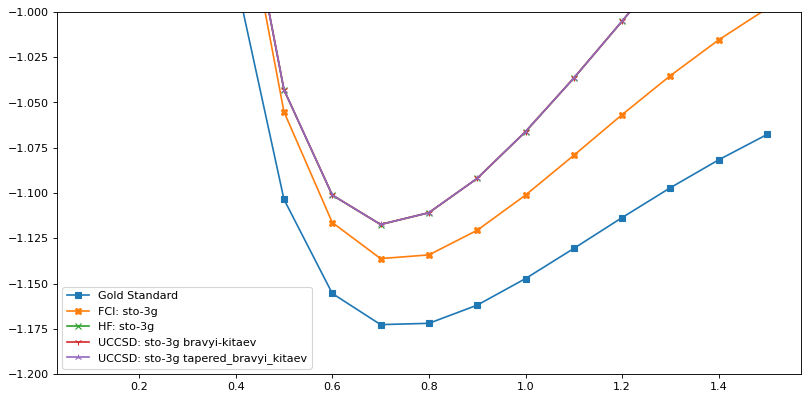

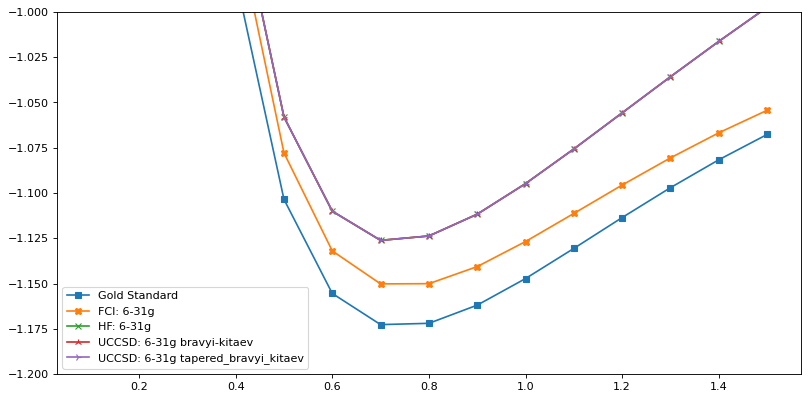

In [11]:
for i, bs in enumerate(basis_sets):
    plt.figure(figsize=(12,6), dpi=80)
    # Plot the gold standard baseline
    plt.plot(molecular_distances, ground_truth, marker="s", label="Gold Standard")
    plt.plot(molecular_distances, experiment_truth[bs], marker="X", label="FCI: "+bs)
    plt.plot(molecular_distances, experiment_approximation[bs], marker="x", label="HF: "+bs)
    for j, tf in enumerate(transformations):
        plt.plot(molecular_distances, [result.energy for result in all_results[" ".join([bs, tf])]], marker=f"{j*(i+1)+(i+1)}", label="UCCSD: "+bs+" "+ tf)
    
    plt.ylim([-1.2, -1.])
    plt.legend()
    plt.show()

# Energy curves versus each other with "gold standard"

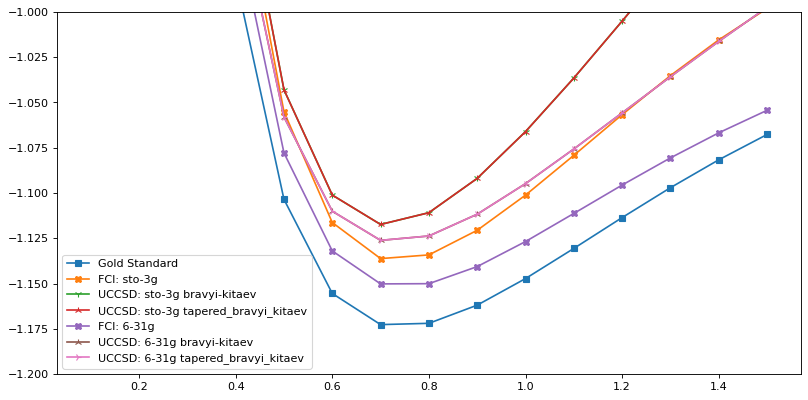

In [12]:
plt.figure(figsize=(12,6), dpi=80)
# Plot the gold standard baseline
plt.plot(molecular_distances, ground_truth, marker="s", label="Gold Standard")
for i, bs in enumerate(basis_sets):
    plt.plot(molecular_distances, experiment_truth[bs], marker="X", label="FCI: "+bs)
    for j, tf in enumerate(transformations):
        plt.plot(molecular_distances, [result.energy for result in all_results[" ".join([bs, tf])]], marker=f"{j*(i+1)+(i+1)}", label="UCCSD: "+bs+" "+ tf)

plt.ylim([-1.2, -1.])
plt.legend()
plt.show()

## Error versus circuit depth
Depth determined by Tequila's `QCircuit.depth` property.

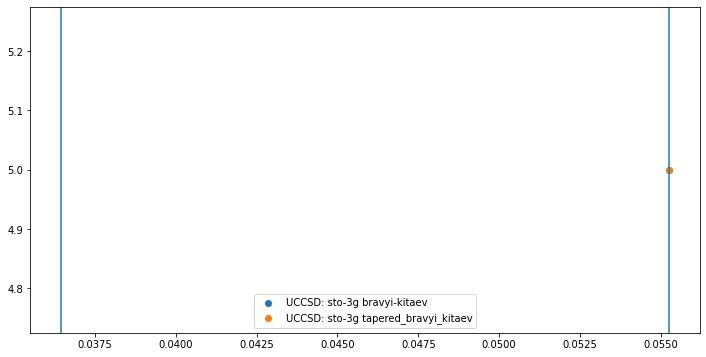

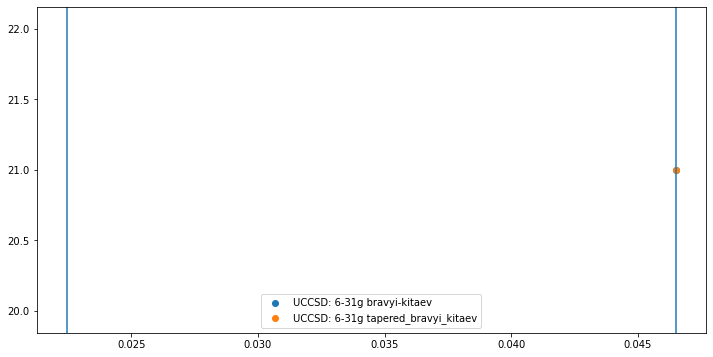

In [19]:
bond_distance = np.argmin(ground_truth)
truth = ground_truth[bond_distance]
for bs in basis_sets:
    plt.figure(figsize=(12,6))
    fci_line = experiment_truth[bs][bond_distance] - truth
    hf_line = experiment_approximation[bs][bond_distance] - truth
    plt.axvline(x=fci_line)
    plt.axvline(x=hf_line)
    for tf in transformations:
        depth = all_results[" ".join([bs, tf])][bond_distance].depth
        error = all_results[" ".join([bs, tf])][bond_distance].energy - truth
        plt.scatter([error], [depth], label="UCCSD: "+bs+" "+ tf)
    
    plt.legend()
    plt.show()

# Leaderboard tables
Preprocessing first

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame([{"name":k, 
                    "energies": [r.energy for r in v],
                    "depth": [r.depth for r in v],
                    "distances": molecular_distances,
                    "molecule": "H2",
                    "min distances": molecular_distances[np.argmin([r.energy for r in v])],
                    "min energy": np.min([r.energy for r in v]),
                    "error wrt fci": [x1.energy-x2 for x1,x2 in zip(v, experiment_truth[k.split(" ")[0]])],
                    "error wrt hf": [x1.energy-x2 for x1,x2 in zip(v, experiment_approximation[k.split(" ")[0]])],
                    "error wrt gold standard": [x1.energy-x2 for x1,x2 in zip(v, ground_truth)],
                    "basis set": k.split(" ")[0],
                    "transformation": k.split(" ")[1],
                    "#qubits": v[0].n_qubits
                   } for k,v in all_results.items()])
df.set_index("name",inplace=True)


## Lowest energy found

In [16]:
df.sort_values("min energy")[["molecule", "basis set", "transformation", "#qubits", "min energy"]]

,molecule,basis set,transformation,#qubits,min energy
name,,,,,
6-31g bravyi-kitaev,H2,6-31g,bravyi-kitaev,8,-1.126123
6-31g tapered_bravyi_kitaev,H2,6-31g,tapered_bravyi_kitaev,6,-1.126123
sto-3g bravyi-kitaev,H2,sto-3g,bravyi-kitaev,4,-1.117349
sto-3g tapered_bravyi_kitaev,H2,sto-3g,tapered_bravyi_kitaev,2,-1.117349


## Closest minimum to "gold standard" minimal energy bond distance

In [17]:
true_bond_distance = molecular_distances[np.argmin(ground_truth)]
df.sort_values("min distances", key=lambda x:x-true_bond_distance)[["molecule", "basis set", "transformation", "#qubits", "min energy", "min distances"]]

,molecule,basis set,transformation,#qubits,min energy,min distances
name,,,,,,
sto-3g bravyi-kitaev,H2,sto-3g,bravyi-kitaev,4,-1.117349,0.7
sto-3g tapered_bravyi_kitaev,H2,sto-3g,tapered_bravyi_kitaev,2,-1.117349,0.7
6-31g bravyi-kitaev,H2,6-31g,bravyi-kitaev,8,-1.126123,0.7
6-31g tapered_bravyi_kitaev,H2,6-31g,tapered_bravyi_kitaev,6,-1.126123,0.7


## Smallest variance in error wrt gold standard

In [18]:
df["variance"] = [np.var(x) for x in df["error wrt gold standard"]]
df.sort_values("variance")[["molecule", "basis set", "transformation", "#qubits", "min energy", "variance"]]

,molecule,basis set,transformation,#qubits,min energy,variance
name,,,,,,
6-31g bravyi-kitaev,H2,6-31g,bravyi-kitaev,8,-1.126123,0.000186
6-31g tapered_bravyi_kitaev,H2,6-31g,tapered_bravyi_kitaev,6,-1.126123,0.000186
sto-3g tapered_bravyi_kitaev,H2,sto-3g,tapered_bravyi_kitaev,2,-1.117349,0.002333
sto-3g bravyi-kitaev,H2,sto-3g,bravyi-kitaev,4,-1.117349,0.002333
